In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model import wrn_28_2
import torch
from tqdm import tqdm
import torch.nn.functional as F
from ema import EMA,EMADriver, set_ema_model
from train import trainer
from eval import predict, eval
from tqdm import tqdm
from semilearn import get_dataset, get_data_loader, get_net_builder, get_algorithm, get_config, Trainer
from semilearn.datasets.cv_datasets import get_cifar
import argparse
from semilearn.core.utils import get_dataset, get_data_loader, get_optimizer, get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt
from flexmatch import FlexMatch

/opt/conda/envs/usb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda:0')

m = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
_=m.to(device)
ema = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
ema = set_ema_model(ema, m)
emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
# emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
emaA.before_run()
NUM_CLASSES=10
args_d = {'dataset': 'cifar10',
         'num_classes': NUM_CLASSES,
         'train_sampler': 'RandomSampler',
         'num_workers': 0,
         'lb_imb_ratio': 1,
         'ulb_imb_ratio':1.0,
          'batch_size': 32,
         'ulb_num_labels': 150,
         'img_size': 32,
         'crop_ratio': 0.875,
         'num_labels': 30,
         'seed': 1,
         'epoch': 3,
         'num_train_iter':150,
         'net': 'wrn_28_8',
         'optim': 'SGD',
         'lr': 0.03,
         'momentum': 0.9,
         'weight_decay': 0.0005,
         'layer_decay': 0.75,
          'num_warmup_iter': 0,
         'algorithm': None,
         'data_dir': './data',
         'uratio': 3,
         'eval_batch_size': 64}

parser = argparse.ArgumentParser(description='Semi-Supervised Learning (USB semilearn package)')
args = parser.parse_args("")
# args
for k in args_d:
        setattr(args, k, args_d[k])
# lb_dset, ulb_dset, eval_dset = get_cifar(args,
#           alg=None, 
#           name='cifar10',
#           num_labels=4000,
#           num_classes=10,
#           data_dir='./data',
#           include_lb_to_ulb=True)
dataset_dict = get_dataset(args, 
                           args.algorithm, 
                           args.dataset, 
                           args.num_labels, 
                           args.num_classes, 
                           data_dir=args.data_dir,
                          include_lb_to_ulb=False)
train_lb_loader = get_data_loader(args, dataset_dict['train_lb'], args.batch_size)
train_lb_loader = get_data_loader(args, dataset_dict['train_lb'], args.batch_size)
train_ulb_loader = get_data_loader(args, dataset_dict['train_ulb'], int(args.batch_size * args.uratio))
eval_loader = get_data_loader(args, dataset_dict['eval'], args.eval_batch_size)

optimizer = get_optimizer(m, args.optim, args.lr, args.momentum, args.weight_decay, args.layer_decay)
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            args.num_train_iter,
                                            num_warmup_steps=args.num_warmup_iter)
loss_ce = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
lb count: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
ulb count: [15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
Files already downloaded and verified


In [10]:
# f = FlexMatch(T, 
#              p_cutoff, 
#              ulb_dest_len=len(dataset_dict['train_ulb']),
#              num_classes=10,
#              model=m)

# m = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
# _=m.to(device)
# ema = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
# ema = set_ema_model(ema, m)
# emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
# emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
# emaA.before_run()

f = FlexMatch(T=1.0, 
             p_cutoff=0.95, 
             ulb_dest_len=len(dataset_dict['train_ulb']),
             num_classes=NUM_CLASSES,
             model=m,
             ema_model=ema,
             loss_ce=loss_ce,
             scheduler=scheduler,
             optimizer=optimizer,
             device=device,
             train_lb_loader=train_lb_loader,
             train_ulb_loader=train_ulb_loader,
             ulb_loss_ratio=1.0,
             hard_label=True, 
             thresh_warmup=True)

In [11]:
steps, sup_loss,unsup_loss,total_loss, mask_ratio = f.fit(epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

idx_lb:  tensor([14, 13, 23, 27, 29,  9, 25,  4,  6, 21, 11, 12, 18, 22, 20, 26,  0, 10,
        16,  7, 15,  2, 19,  8, 17, 24,  3,  1,  5, 28,  0,  3],
       device='cuda:0')
idx_ulb:  tensor([ 44,  54,  95,  75,  35,  69, 121,  84,  49, 108, 131, 124,  78,  73,
         11,  26, 130,  47, 116,  29, 136,   2, 109,  52, 140,  18,  31,  25,
         99,  71,  15,  87, 133, 102, 117,  40,  20, 146,  53,  64,  48,  27,
         58,  98, 147,  77,  97, 139,  37, 129,  90,  80,  83, 148, 149,  85,
          8,  67,  74, 138,  22,  94,  65,   5,   0, 135,  36, 142, 106,  66,
        107, 120,  72,  50,  42,   4, 101,   7,  79, 111, 132, 128,  61,  62,
        141,  43, 127,  38, 119, 115, 145, 137,  59,  32, 113,  10],
       device='cuda:0')
idx_lb:  tensor([ 2, 20,  8, 25, 27, 22,  6, 17, 18, 16, 15, 10, 12, 11,  4, 29,  5, 14,
        21, 13, 23, 26,  1,  7, 24,  9, 28, 19, 26, 19,  5, 16],
       device='cuda:0')
idx_ulb:  tensor([112,  39,  12,  13, 105,  86,  68,  30,  41,  19,  57, 

Traceback (most recent call last):
  File "/opt/conda/envs/usb/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/conda/envs/usb/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/envs/usb/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/envs/usb/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  0%|          | 0/30 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [6]:
# mask_ratio

In [7]:
# !nvidia-smi

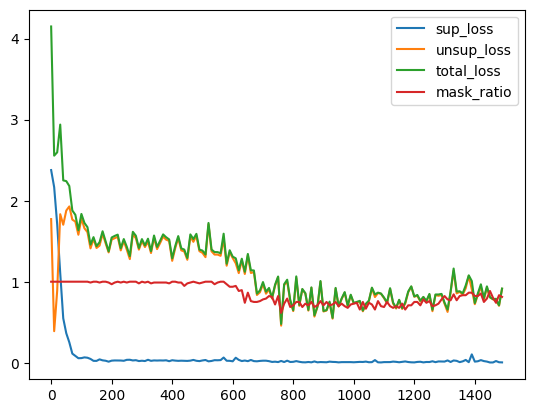

In [8]:
plt.plot(steps,sup_loss)
plt.plot(steps,unsup_loss)
plt.plot(steps,total_loss)
plt.plot(steps,mask_ratio)
#mask_ratio
plt.legend(['sup_loss','unsup_loss','total_loss','mask_ratio'])
plt.show()

100%|██████████| 50/50 [00:02<00:00, 24.65it/s]
/opt/conda/envs/usb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


top1 0.1740625 0.1328125


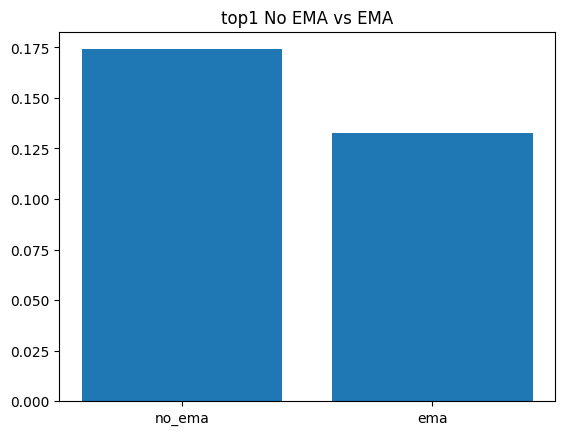

balanced_top1 0.17216412294329286 0.1327547024022489


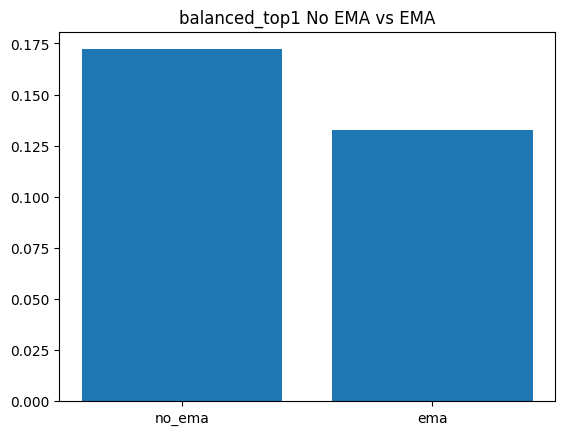

precision 0.16722307311238074 0.078543967679686


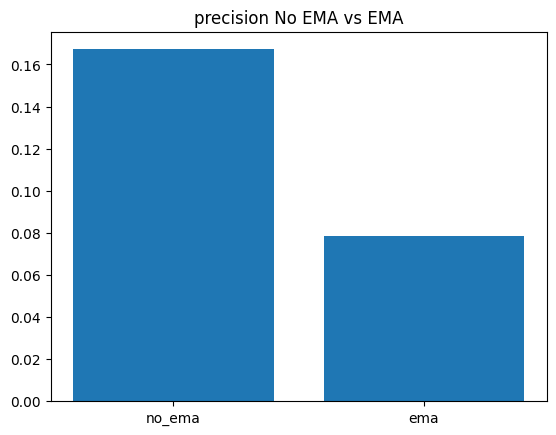

recall 0.17216412294329286 0.1327547024022489


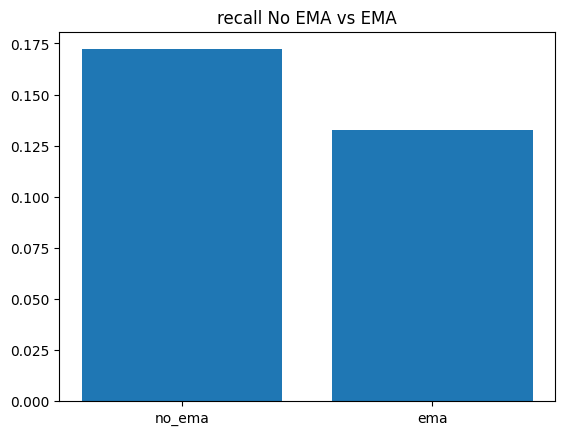

F1 0.15409226814283017 0.07833870511126795


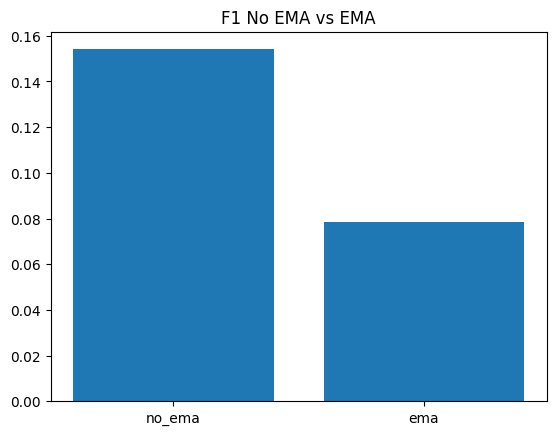

In [9]:
top1,balanced_top1, precision, recall, F1, cf_mat  = eval(m,emaA.ema,eval_loader,device,return_gt=True,use_ema_model=False)
no_ema = {
    'top1':top1,
    'balanced_top1':balanced_top1,
    'precision':precision,
    'recall':recall,
    'F1':F1,
    'cf_mat':cf_mat
}
top1,balanced_top1, precision, recall, F1, cf_mat  = eval(m,emaA.ema,eval_loader,device,return_gt=True,use_ema_model=True)
ema_res = {
    'top1':top1,
    'balanced_top1':balanced_top1,
    'precision':precision,
    'recall':recall,
    'F1':F1,
    'cf_mat':cf_mat
}
for k in ema_res.keys():
    if k!='cf_mat':
        print(k,no_ema[k],ema_res[k])
        plt.bar(['no_ema','ema'],[no_ema[k],ema_res[k]])
        plt.title("{} No EMA vs EMA".format(k))
        plt.show()